# Cyclists Dataset Understanding

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
races = pd.read_csv("../data/races.csv")

In [4]:
dataset = pd.read_csv("../data/cyclists.csv")
dataset.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


In [5]:
dataset.info()
# birth year, heigth -> float to int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


In [6]:
dataset.isnull().sum()

_url              0
name              0
birth_year       13
weight         3056
height         2991
nationality       1
dtype: int64

In [7]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset) # compute the percentage of missing values
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})

missing_value_df['percent_missing']

_url            0.000000
name            0.000000
birth_year      0.211933
weight         49.820672
height         48.761004
nationality     0.016303
Name: percent_missing, dtype: float64

In [8]:
missing_birthyear = dataset[dataset['birth_year'].isnull()]['_url'].to_list()
dataset[dataset['birth_year'].isnull()]

,_url,name,birth_year,weight,height,nationality
9,scott-davies,Scott Davies,NaN,NaN,NaN,NaN
601,vladimir-malakov,Vladimir Malakov,NaN,NaN,NaN,Russia
894,antonio-zanini,Antonio Zanini,NaN,NaN,NaN,Italy
2408,filippo-simonetti,Filippo Simonetti,NaN,NaN,NaN,Italy
2515,carlos-garcia,Carlos García,NaN,NaN,NaN,Spain
2536,alexandr-osipov,Alexandr Osipov,NaN,NaN,NaN,Russia
3046,nicolai-kosyakov,Nicolai Kosyakov,NaN,NaN,NaN,Russia
3551,nevens-guy,Guy Nevens,NaN,NaN,NaN,Belgium
4142,oscar-pumar,Oscar Pumar,NaN,NaN,NaN,Venezuela
4384,javier-luquin,Javier Luquin,NaN,NaN,NaN,Spain


### Tentativo di imputazione manuale delle date di nascita mancanti sfruttando i dati del dataset 'races.csv'

I ciclisti nel dataset 'cyclist.csv' hanno età NaN in ogni record del dataset 'races.csv'

In [9]:
# cyclist
tmp_df = races[races['cyclist'].isin(missing_birthyear)]
tmp_df[tmp_df['cyclist_age'].notnull()]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta


Abbiamo cercato di recuperare più dati possibile manualmente attraverso ricerce online supportate da confronti diretti con altri dati presenti nel dataset 'races.csv'

Una volta identificato un ciclista con alta probabilità abbiamo fatto una imputazione manuale del valore ottenuto nella feature 'birth_year' corrispondente

In [10]:
dataset.loc[dataset['_url'] == 'scott-davies', 'birth_year'] = 1995
dataset.loc[dataset['_url'] == 'vladimir-malakov', 'birth_year'] = 1958
dataset.loc[dataset['_url'] == 'antonio-zanini', 'birth_year'] = 1965
dataset.loc[dataset['_url'] == 'nevens-guy', 'birth_year'] = 1962
dataset.loc[dataset['_url'] == 'sergei-jermachenko', 'birth_year'] = 1956 

Ragionamento simile fatto anche per la nazionalità. L'unica mancante apparteneva al ciclista Scott Davies che era già stato correttamente identificato nella fase precedente, grazie a cui abbiamo rivenuto anche questa informazione

In [11]:
dataset.loc[dataset['_url'] == 'scott-davies', 'nationality'] = 'Great Britain'

In [12]:
dataset.isnull().sum() # check if missing values are filled correctly

_url              0
name              0
birth_year        8
weight         3056
height         2991
nationality       0
dtype: int64

In [13]:
dataset.describe()

,birth_year,weight,height
count,6126.000000,3078.000000,3143.000000
mean,1974.066275,68.658739,179.815145
std,15.536065,6.348183,6.443447
min,1933.000000,48.000000,154.000000
25%,1962.000000,64.000000,175.000000
50%,1974.000000,69.000000,180.000000
75%,1987.000000,73.000000,184.000000
max,2004.000000,94.000000,204.000000


Ricerca di valori di default che nascondono valori mancanti

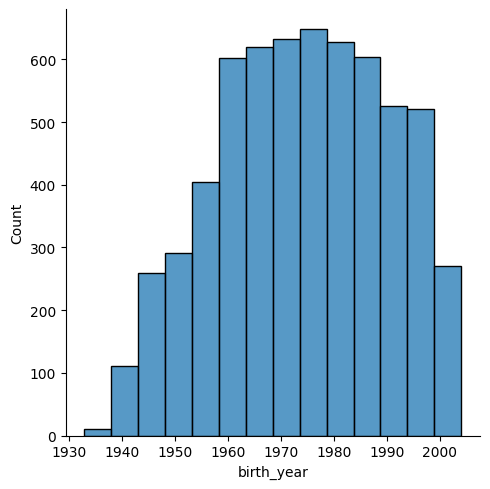

In [14]:
n_bins = math.ceil(math.log2(len(dataset)) + 1)

sb.displot(dataset, 
                x="birth_year", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

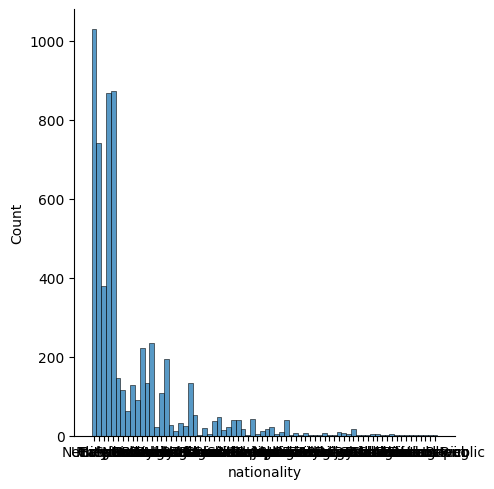

In [15]:
sb.displot(dataset, 
                x="nationality", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['nationality'].unique()))